# **Atakeen sailkapena konputagailuen arteko komunikazioetan grafo egiturak erabiliz, errepikatutako ertzak ezabatuz**

Beharko ditugun liburutegiak:

In [3]:
from google.colab import drive
import numpy as np
import pandas as pd
from scipy import stats
from typing import List, Tuple
from sklearn import metrics, linear_model
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import networkx as nx
import os
from scipy.linalg import fractional_matrix_power
import csv
import math
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear

Instalatu beharrekoak:

In [ ]:
!pip install torch_geometric
!pip install pandas
!pip install numpy
!pip install scipy==1.8.0
!pip install networkx

## **Datuak kargatzen**

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## **CSV-ak irakurri eta bakar batean elkartu**

BETH datu-multzoa CSV desberdinetan banatuta dago. Beraz, taula hauek batean batu behar dira.

In [5]:
path = '/content/drive/MyDrive/GrAL/DATUAK/ELKARTZEKO'
files = [os.path.join(path, file) for file in os.listdir(path)]
taula = pd.concat(map(pd.read_csv, files), ignore_index=True)
originala = pd.concat(map(pd.read_csv, files), ignore_index=True)

##**CSV-a moldatu**

Bi taula desberdin erabiliko dira, taula originala, aldaketarik gabekoa, eta moldatutako taula, honek datuak aurreprozesatuta gordeko ditu.

In [6]:
taula = taula[["processId", "parentProcessId", "userId", "eventId", "argsNum", "returnValue", "evil"]]
originala = originala[["processId", "parentProcessId", "userId", "eventId", "argsNum", "returnValue", "evil"]]

# Preprocessing
taula["processId"] = taula["processId"].map(lambda x: 1 if x in [0, 1, 2] else 0)
taula["parentProcessId"] = taula["parentProcessId"].map(lambda x: 1 if x in [0, 1, 2] else 0)
taula["userId"] = taula["userId"].map(lambda x: 1 if x < 1000 else 0)
taula["eventId"] = taula["eventId"]
taula["argsNum"] = taula["argsNum"]
taula["returnValue"] = taula["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))

# CSV berriak sortu
taula.to_csv('dataset.csv')
originala.to_csv('orig_dataset.csv')

## **Ezaugarrien zerrenda prestatzeko**

In [8]:
# Aurre-prozesatua
with open('/content/dataset.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]

# Originala
with open('/content/orig_dataset.csv',newline='') as f:
    r2 = csv.reader(f)
    data_orig = [line for line in r2]

In [9]:
#Initialize the graph
G = nx.DiGraph(name='G')   # Zuzendua

In [10]:
# EZAUGARRIEN ZERRENDA
nodoak = []
ezaugarriak = []

for i in range(1, len(data_orig)):

  if int(data_orig[i][1]) in nodoak:
    ind = nodoak.index(int(data_orig[i][1]))

    if (ezaugarriak[ind][1]==-1000.0):
      ezaugarriak[ind][0] = 1.0
      ezaugarriak[ind][1] = float(data[i][1])
      ezaugarriak[ind][2] = float(data[i][2])
      ezaugarriak[ind][3] = float(data[i][3])
      ezaugarriak[ind][4] = float(data[i][4])
      ezaugarriak[ind][5] = float(data[i][5])
      ezaugarriak[ind][6] = float(data[i][6])

    else:
      ezaugarriak[ind][0] = ezaugarriak[ind][0]+1
      if data[i][1]=='1':
        ezaugarriak[ind][1] = 1.0
      elif data[i][2]=='1':
        ezaugarriak[ind][2] = 1.0
      elif data[i][3]=='1':
        ezaugarriak[ind][3] = 1.0

      #ezaugarriak[ind][4]
      ezaugarriak[ind][5] = ezaugarriak[ind][5] + float(data[i][5])

      # Ezaugarri hau returnValue da, eta aurreprozesatuta dago. 0, 1 edo 2 balioak ditu.
      ezaugarriak[ind][6] = ezaugarriak[ind][6] + float(data[i][6])


  if not int(data_orig[i][1]) in nodoak:
    nodoak.append(int(data_orig[i][1]))
    ezaugarriak.append([1.0, float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6])])

  if not int(data_orig[i][2]) in nodoak:
    nodoak.append(int(data_orig[i][2]))
    ezaugarriak.append([0.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0])   # "-inf"-ekin erabili ostian, erroreak NaN delako infinito, visualize egitean erroreak.


In [11]:
# Batezbestekoa kalkulatzeko (ahal den aldagaietan)
for i in range(0, len(ezaugarriak)):
  if (ezaugarriak[i][0] > 1):
    ezaugarriak[i][5] = ezaugarriak[i][5]/ezaugarriak[i][0]

    # Ezaugarri hau returnValue da, eta aurreprozesatuta dago. 0, 1 edo 2 balioak ditu.
    ezaugarriak[i][6] = ezaugarriak[i][6]/ezaugarriak[i][0]

In [12]:
kop = 0

# GRAFOA
for i in range(1, len(data_orig)):

  if not G.has_node(data_orig[i][2]):   # Parent
    G.add_node(data_orig[i][2], name=kop, evil=data[i][7])   #ezaugarriak adierazteko
    kop = kop+1
  else:
    if data[i][7]=='1':
      G.nodes[data_orig[i][2]]["evil"] = '1'

  if not G.has_node(data_orig[i][1]):   # Child
    G.add_node(data_orig[i][1], name=kop, evil='0')   #ezaugarriak adierazteko
    kop = kop+1

  G.add_edge(data_orig[i][2], data_orig[i][1])

# **`Data` motako objektuak**

Orain arte, grafoak **`DiGraph`** motatako objektuak dira, baina neurona-sarean grafoak entrenatzeko zein testeatzeko PyTorch Geometric liburutegiarekin bateragarria den grafo mota behar da. PyTorch Geometric-en, grafoak **`Data`** izeneko objektuetan errepresentatzen dira, honako ezaugarriekin:

#### **x**
Grafoaren ezaugarri-matrizea da (hau da, grafoaren nodo bakoitzeko ezaugarriez osatutako zutabeak dituen matrizea).

**shape** `[num_nodes, num_node_features]`

In [13]:
scaler = MinMaxScaler()
new_x = scaler.fit_transform(ezaugarriak)
x = torch.tensor(new_x, dtype=torch.float)
x.size()

torch.Size([1799, 7])

#### **edge_index**
Grafoaren konektibitate-matrizea da, COO formatuan. Konektatuta dauden nodoen zerrenda bakarrik gordetzen da, grafoaren auzokide matrize osoa gorde beharrean.

**shape** `[2, num_edges]`

In [14]:
# Nodo guztien zerrenda lortzeko
nodo = []
for i in range(0, len(list(G.nodes.data()))):
  nodo.append(list(G.nodes.data())[i][0])
  nodo.append(int(list(G.nodes.data())[i][1]["name"]))


# Grafoaren ertz guztien zerrenda lortzeko
ertzak = []
for i in range(0, len(list(G.edges))):
  ind_guraso = nodo.index(list(G.edges)[i][0])
  ind_ume = nodo.index(list(G.edges)[i][1])
  ertzak.append([nodo[ind_guraso+1], nodo[ind_ume+1]])


# edge_index tensore bat denez, eraldatu
matrix = np.transpose(ertzak)

edge_index = torch.tensor(matrix)
print("Edge index: ", edge_index)
edge_index.size()

Edge index:  tensor([[   0,    0,    0,  ..., 1792, 1794, 1797],
        [   1,    5,    6,  ..., 1793, 1795, 1798]])


torch.Size([2, 4466])

#### **y**
Nodo bakoitzaren etiketa-matrizea da (bi klasetatik nodo bakoitza zeini dagokion adieraziko du).

In [15]:
matrix = []
for i in range(0, len(list(G.nodes.data()))):
  matrix.append(int(list(G.nodes.data())[i][1]['evil']))

y = torch.tensor(matrix)

In [16]:
# Zenbat nodo erasotzaile dauden guztira eta indizeak
kont = 0
indizeak = []
for k in range(0, len(y)):
  if (y[k]==1):
    indizeak.append(k)
    kont = kont+1

print("Kopurua: ", kont)
print("Indizeak: ", indizeak)

Kopurua:  14
Indizeak:  [0, 277, 279, 368, 376, 449, 451, 453, 455, 458, 466, 904, 931, 1285]


#### **Data objektua sortzeko**

In [18]:
# Data objektua sortzen
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, y=y)

In [19]:
# train_mask lortzeko
# Entrenamendu-multzoan dataseteko zein nodo dauden adierazten duen matrize bitarra da.
a = np.zeros(718)
b = np.ones(1081)
data.train_mask = torch.tensor(np.concatenate((a,b)), dtype=torch.bool)

# test_mask lortzeko
# Proba-multzoan dataseteko zein nodo dauden adierazten duen matrize bitarra da.
c = np.ones(718)
d = np.zeros(1081)
data.test_mask = torch.tensor(np.concatenate((c,d)), dtype=torch.bool)

In [20]:
# Data objektuaren ezaugarriak
print("Nodoen ezaugarri kopurua: ", data.num_features)
print("Data: ", data)
print("Nodo kopurua: ", data.num_nodes)
print("Ertz kopurua: ", data.num_edges)

Nodoen ezaugarri kopurua:  7
Data:  Data(x=[1799, 7], edge_index=[2, 4466], y=[1799], train_mask=[1799], test_mask=[1799])
Nodo kopurua:  1799
Ertz kopurua:  4466


## **GCN EREDUA**

GCN eredua sortzen da, lau GCNConv geruzarekin.

In [21]:
class GCN(torch.nn.Module):

    def __init__(self, hidden_channels, num_features, num_classes):
        # __init__()-en, klase nagusira deitu behar da bigarren klaseari esleipenak egin aurretik.
        super().__init__()

        # Ausazko zenbakiak sortzeko hazia ezartzen du. torch.Generator motako objektua itzultzen du.
        # PyTorchen ausazkotasuna kontrolatzen laguntzen duen funtzioa da.
        torch.manual_seed(42)

        # INITIALIZING THE LAYERS
        # Lehenengo, GCN geruza kopurua definitzen da.
        # Kasu honetan, Message Passing-a burutzeko lau geruza ditu.
        # GCN layers (message passing layers)
        self.conv1 = GCNConv(num_features, hidden_channels)     # Lehenengo geruza
        self.conv2 = GCNConv(hidden_channels, hidden_channels)      # Bigarren geruza
        self.conv3 = GCNConv(hidden_channels, hidden_channels)      # Hirugarren geruza
        self.conv4 = GCNConv(hidden_channels, hidden_channels)      # Laugarren geruza

        # Transformazio lineal bakarra aplikatzen da (torch.nn.Linear), eta honek, sailkatzaile gisa jarduten du (nodoak 0 edo 1 klasean sailkatzeko).
        # Output layer, sailkatzailea
        self.out = Linear(hidden_channels, num_classes)


    # Sarearen konputazio-fluxua definitzeko (forward)
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()      # Lehenengo Message Passing Layer
        h = self.conv2(h, edge_index).relu()      # Bigarren Message Passing Layer
        h = self.conv3(h, edge_index).relu()      # Hirugarren Message Passing Layer
        h = self.conv4(h, edge_index).relu()      # Laugarren Message Passing Layer
        out = self.out(h)
        return out, h


In [23]:
# num_features --> Nodoen ezaugarri kopurua (data.num_features)
# num_classes = 2 (Erasoa edo ez, hau da, nodo bat erasotzailea den edo ez)
# Ereduak 16 kanal ezkutu izango ditu.
model = GCN(hidden_channels=16, num_features=7, num_classes=2)

# Sare-arkitektura definitzeaz gain, CrossEntropyLoss funtzioa definitzen da, eta Adam optimizatzailea hasieratzen da.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():

      # model.train() funtzioak, eredua entrenatzen ari dela adierazten du, hau da, ez du eredua entrenatzen, baizik eta modua ezartzen du. Honek, Dropout
      # eta BatchNorm bezalako geruzak informatzen laguntzen du, entrenamenduan eta ebaluazioan desberdin jokatzeko diseinatuta baitaude.
      # Adibidez, entrenamendu-moduan, BatchNorm-ek batezbesteko mugikor bat eguneratzen du lote berri bakoitzean; ebaluaziorako, berriz, eguneratze horiek
      # izoztuta daude.
      model.train()

      for epoch in range(10):
        optimizer.zero_grad()  # Gradienteak zeroan jarri
        out, h = model(data.x, data.edge_index)  # Forward urrats bat aplikatu
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Galera kalkulatzen da soilik entrenamendu-nodoetan oinarrituta
        loss.backward()  # Gradienteak deribatu
        optimizer.step()  # Gradienteetan oinarritutako parametroak eguneratzen dira

      pred = out.argmax(dim=1)  # Probabilitate handiena duen klasea erabiltzen da
      train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Entrenamenduan ongi sailkatutako nodo kopurua
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Accuracy-a

      return pred[data.train_mask], data.y[data.train_mask], train_correct.sum(), train_acc

def test():
      model.eval()      # model.eval() erabiltzean ereduari adierazten zaio ez dela ezer berririk ikasi behar, eta eredua probatzeko erabiltzen da.
      out, h = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Probabilitate handiena duen klasea erabiltzen da
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Ongi sailkatutako nodo kopurua
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Accuracy-a
      return pred[data.test_mask], data.y[data.test_mask], test_correct.sum(), test_acc

#### **TRAIN**

In [24]:
# Eredua entrenatzen da
pred, actual, train_correct, train_acc = train()

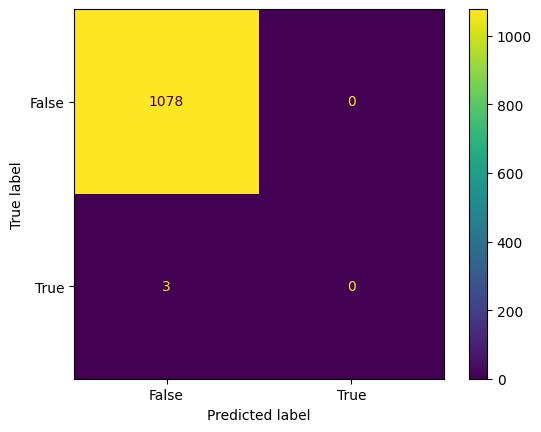

In [25]:
# Entrenamenduaren konfusio-matrizea
# True Negative (Top-Left Quadrant)
# False Positive (Top-Right Quadrant)
# False Negative (Bottom-Left Quadrant)
# True Positive (Bottom-Right Quadrant)

confusion_matrix = metrics.confusion_matrix(actual, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
# Precision balioek adierazten dute negatibotzat, edo 0 klasean, sailkatu diren datuen artetik zenbat sailkatu direla ondo, eta positibotzat, edo 1 klasean,
# sailkatu diren datuen artetik zenbat sailkatu direla ondo.
metrics.precision_score(actual, pred, average=None)

array([0.99722479, 0.        ])

In [ ]:
# Recall balioek adierazten dute ereduak egiazko negatiboak eta egiazko positiboak identifikatzeko gaitasuna.
metrics.recall_score(actual, pred, average=None)

array([1., 0.])

In [26]:
# F1 balioak
metrics.f1_score(actual, pred, average=None)

array([0.99861047, 0.        ])

#### **TEST**

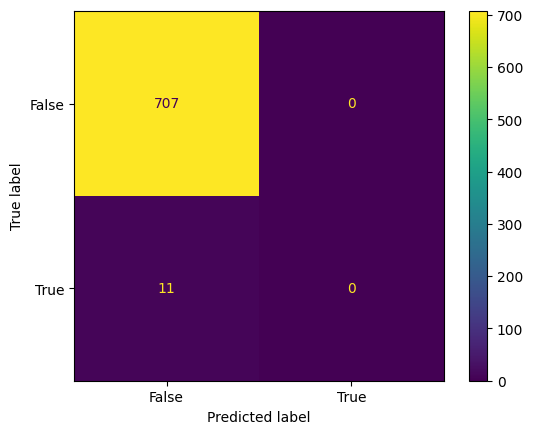

In [27]:
# Eredua probatzen da
pred, actual, test_correct, test_acc = test()

# Test-aren konfusio-matrizea
confusion_matrix = metrics.confusion_matrix(actual, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
# Precision balioak
metrics.precision_score(actual, pred, average=None)

array([0.98467967, 0.        ])

In [ ]:
# Recall balioak
metrics.recall_score(actual, pred, average=None)

array([1., 0.])

In [ ]:
# F1 balioak
metrics.f1_score(actual, pred, average=None)

array([0.9922807, 0.       ])